# Notebook for analysing results of the naming game, matrices visualizations

This notebook can be used for generating videos of all the naming matrices during training for a specific seed. A video of the evolution of the naming matrices will be stored in the experiment's directory

In [1]:
import os
import random
import tempfile
from copy import deepcopy
from datetime import datetime

import click
import imgc_marl.envs.population as population
import numpy as np
import yaml
from imgc_marl.callbacks import (
    PopGoalLinesCallback,
    PopGoalLinesCommunicationCallback,
    PopGoalLinesNamingCallback,
    PopGoalLinesNamingCallback1Matrix,
)
from imgc_marl.evaluation import (
    communication_custom_eval_function,
    custom_eval_function,
)
from imgc_marl.models.basic_communication import BasicCommunicationNetwork
from imgc_marl.models.full_naming_game import FullNamingNetwork
from imgc_marl.models.full_naming_game_single_matrix import FullNamingNetwork1Matrix
from imgc_marl.policies.basic_communication import BasicCommunicationTrainer
from imgc_marl.policies.full_naming_game import FullNamingTrainer
from imgc_marl.policies.full_naming_game_single_matrix import FullNamingTrainer1Matrix
from imgc_marl.utils import keep_relevant_results
from ray.rllib.agents.ppo import DEFAULT_CONFIG, PPOTrainer
from ray.rllib.models import ModelCatalog
from ray.rllib.policy.policy import PolicySpec
from ray.tune.logger import UnifiedLogger, pretty_print
import torch
import matplotlib.pyplot as plt
import moviepy

/home/elias/workspace/imgc-marl/marl-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Select correct configuration file 
* Select environment (3 or 6 landmarks)
* Select the experiment you want to evaluate

In [2]:
from imgc_marl.envs.population import PopGoalLinesEnv, PopLargeGoalLinesEnv

# 3 landmarks
config_file = "goal_lines_naming.yml"
environment = PopGoalLinesEnv

# 6 landmarks
# config_file = "large_goal_lines_naming.yml"
# environment = PopLargeGoalLinesEnv


# directory of the checkpoints you want to evaluate
checkpoints_dir = "/home/elias/september/3_landmarks/classic_reward/2/coop_only/naming_game/2022-09-28_19-04-19p4yy9e4x"

In [3]:
with open(f"../scripts/configs/{config_file}", "r") as f:
    user_config = yaml.safe_load(f)
# General settings of the algorithm
config = deepcopy(DEFAULT_CONFIG)
config["num_workers"] = 0
config["framework"] = "torch"
use_communication = user_config.get("communication", False)

config["horizon"] = population.LARGE_GOAL_LINES_TIMELIMIT
config["rollout_fragment_length"] = config["horizon"]
config["env_config"] = user_config["env_config"]
config["train_batch_size"] = 60_000
config["sgd_minibatch_size"] = 10_000
config["lambda"] = 0.9
config["lr"] = 0.0003


def policy_mapping_fn(agent_id):
    return agent_id


config["multiagent"] = {
    "policies": {
        f"agent_{i}": PolicySpec(
            policy_class=None, observation_space=None, action_space=None
        )
        for i in range(config["env_config"]["population_size"])
    },
    "policy_mapping_fn": policy_mapping_fn,
}

train_env = environment

ModelCatalog.register_custom_model("FullNamingNetwork1Matrix", FullNamingNetwork1Matrix)
number_of_goals = environment(config["env_config"]).goal_space_dim
config["model"] = {
    "custom_model": "FullNamingNetwork1Matrix",
    "custom_model_config": {
        "number_of_goals": number_of_goals,
        "train_matrix": user_config.get("train_matrix", False),
    },
}
trainer = FullNamingTrainer1Matrix(
    config=config,
    env=train_env,
)

2022-09-30 13:52:12,192	WARNING deprecation.py:46 -- DeprecationWarning: `ray.rllib.agents.ppo.ppo.DEFAULT_CONFIG` has been deprecated. Use `ray.rllib.agents.ppo.ppo.PPOConfig(...)` instead. This will raise an error in the future!
2022-09-30 13:52:12,369	WARNING multi_agent_env.py:225 -- observation_space_sample() has not been implemented
2022-09-30 13:52:12,369	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-09-30 13:52:12,370	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-09-30 13:52:12,370	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-09-30 13:52:12,370	WARNING multi_agent_env.py:193 -- action_space_sample() has not been implemented
2022-09-30 13:52:12,370	WARNING multi_agent_env.py:161 -- action_space_contains() has not been implemented
2022-09-30 13:52:12,372	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented

# Inspecting matrices through time

2022-09-30 13:52:20,741	INFO trainable.py:588 -- Restored on 193.50.110.220 from checkpoint: /home/elias/september/3_landmarks/classic_reward/2/coop_only/naming_game/2022-09-28_19-04-19p4yy9e4x/checkpoint_000010/checkpoint-10
2022-09-30 13:52:20,742	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 608.9546136856079, '_episodes_total': 2429}
2022-09-30 13:52:20,918	INFO trainable.py:588 -- Restored on 193.50.110.220 from checkpoint: /home/elias/september/3_landmarks/classic_reward/2/coop_only/naming_game/2022-09-28_19-04-19p4yy9e4x/checkpoint_000020/checkpoint-20
2022-09-30 13:52:20,919	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 1178.437026500702, '_episodes_total': 5335}
2022-09-30 13:52:21,053	INFO trainable.py:588 -- Restored on 193.50.110.220 from checkpoint: /home/elias/september/3_landmarks/classic_reward/2/coop_only/naming_game/2022-09-28_19-

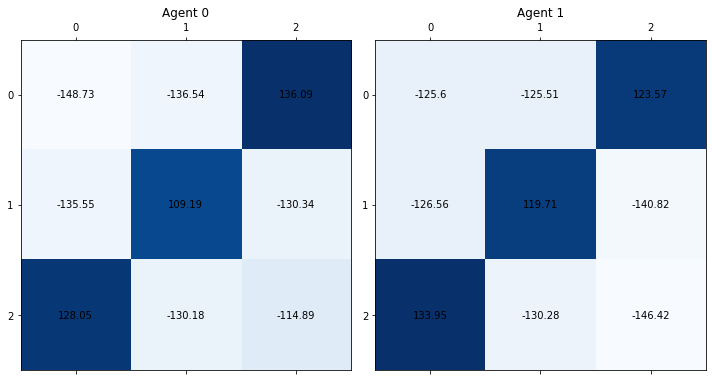

In [4]:
imgs = []
for checkpoint_dir in sorted(os.listdir(checkpoints_dir)):
    if os.path.isdir(os.path.join(checkpoints_dir, checkpoint_dir)):
        checkpoint_file = sorted(
            os.listdir(os.path.join(checkpoints_dir, checkpoint_dir))
        )[1]
        trainer.restore(os.path.join(checkpoints_dir, checkpoint_dir, checkpoint_file))
        agent_0 = trainer.get_policy("agent_0").model
        agent_1 = trainer.get_policy("agent_1").model
        with torch.no_grad():
            agent_0_matrix = agent_0._matrix.numpy()
            agent_1_matrix = agent_1._matrix.numpy()

            # Generate images
            for j, matrix in enumerate((agent_0_matrix, agent_1_matrix)):
                if j == 0:
                    fig = plt.figure(num=1, clear=True, figsize=(10, 10))
                    ax = fig.add_subplot(121)
                    ax.set_title("Agent 0")
                elif j == 1:
                    ax = fig.add_subplot(122)
                    ax.set_title("Agent 1")
                ax.matshow(matrix, cmap=plt.cm.Blues)
                for x in range(number_of_goals):
                    for y in range(number_of_goals):
                        c = matrix[y, x]
                        ax.text(x, y, str(round(c, 2)), va="center", ha="center")
                if j == 1:
                    plt.tight_layout()
                    canvas = fig.figure.canvas
                    canvas.draw()
                    data = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
                    img = data.reshape(canvas.get_width_height()[::-1] + (3,))
                    imgs.append(img)

In [5]:
matrix_video = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(imgs, fps=0.5)

matrix_video.write_videofile(os.path.join(checkpoints_dir, "naming_game.mp4"))

Moviepy - Building video /home/elias/september/3_landmarks/classic_reward/2/coop_only/naming_game/2022-09-28_19-04-19p4yy9e4x/naming_game.mp4.
Moviepy - Writing video /home/elias/september/3_landmarks/classic_reward/2/coop_only/naming_game/2022-09-28_19-04-19p4yy9e4x/naming_game.mp4



Moviepy - Done !
Moviepy - video ready /home/elias/september/3_landmarks/classic_reward/2/coop_only/naming_game/2022-09-28_19-04-19p4yy9e4x/naming_game.mp4
